# Traveling Salesman Problem (TSP)

In [3]:
using Pkg
Pkg.activate(".")

using LinearAlgebra
using Printf
using Random

using Gurobi
using JuMP

using Plots

  Activating environment at `~/Git/or_tutorials/callbacks/Project.toml`
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


## Problem formulation

In [2]:
function generate_tsp_data(N; seed=42)
    Random.seed!(seed)
    
    # Sample coordinates
    X = rand(N, 2)
    
    # Compute Euclidean distances
    D = zeros(N, N)
    for i in 1:N
        xᵢ = X[i, :]
        for j in (i+1):N
            xⱼ = X[j, :]
            # Euclidean distances
            D[i, j] = norm(xᵢ - xⱼ, 2)
        end
    end
    
    # Symmetrize the dis
    D .+= D'
    
    return X, D
end

generate_tsp_data (generic function with 1 method)

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1342
┌ Warning: Module Glib_jll with build ID 512745726695908 is missing from the cache.
│ This may mean Glib_jll [7746bdde-850d-59dc-9ae8-88ece973131d] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030


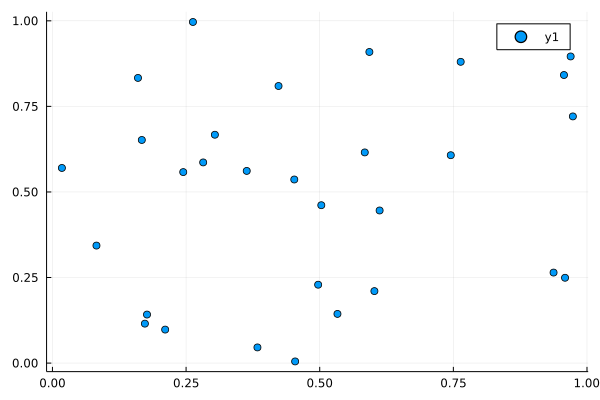

In [4]:
N = 30
X, D = generate_tsp_data(N)

scatter(X[:, 1], X[:, 2])

## Lazy constraints

## Heuristics